
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.25
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#BEACS Set Up
DO_ZIP = True
DO_GA = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2
BETA_ALP = 0.05

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ A ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1h 13min 57s, sys: 14.1 s, total: 1h 14min 11s
Wall time: 1h 15min 5s


### Performance

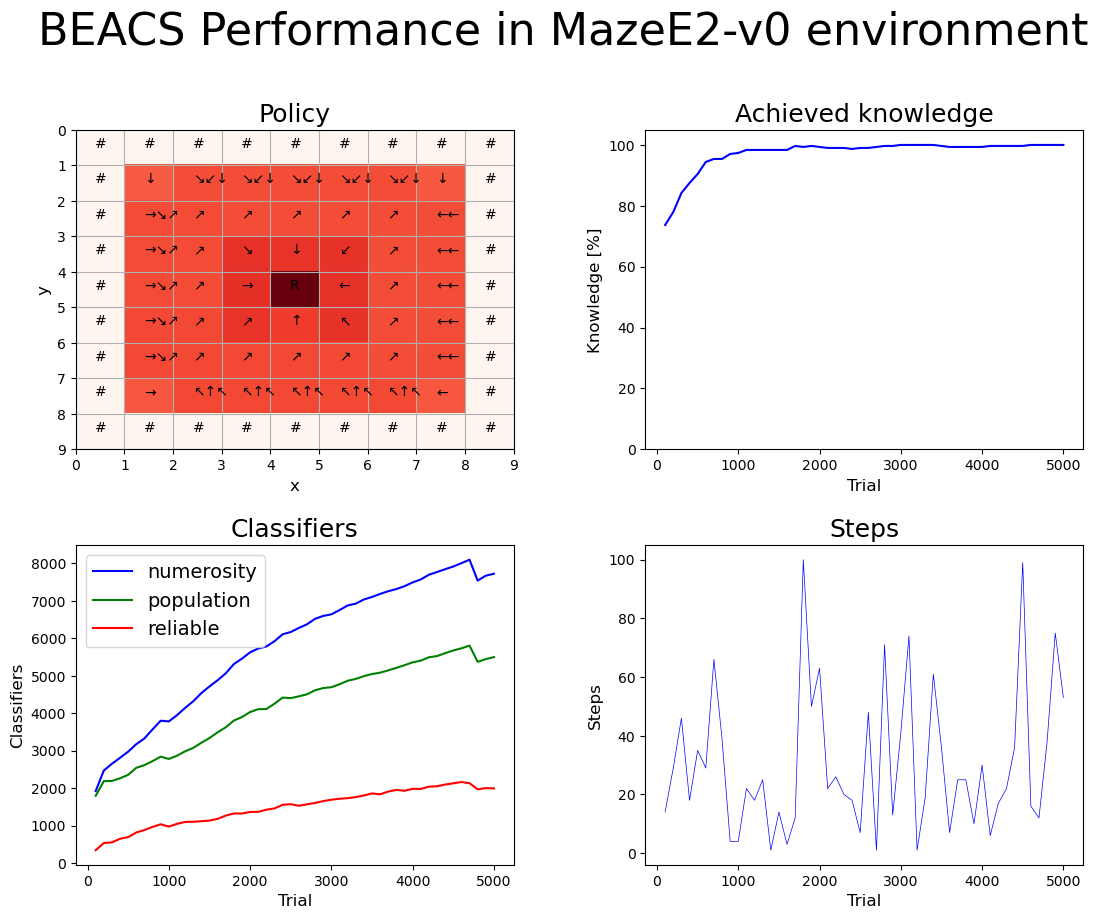

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  3000 , was stable at  4600  and the last time it was achieved at  5000
There are  830  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 100.0, 'population': 5499, 'numerosity': 7724, 'reliable': 1993}
Mean reliable population specifity is  0.8776969392875063
Accumulated Error on PEP Probabilities : 4.8396510909335335 %

{'knowledge': 100.0, 'population': 2983, 'numerosity': 4721, 'reliable': 574}
Mean reliable population specifity is  0.7761324041811847
Accumulated Error on PEP Probabilities : 4.800971837370683 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

#0900000 2 None (##0#####:#232, ##0#9###:#7, #90#####:#7) (00900000)
q: 0.9992 ra: 987.3  rb: 983.8  ir: 883.0  f: 986.5  err: 25.64 
exp: 212   num: 1 ee: True PAI_state: 
tga: 141979 tbseq: 140939 talp: 141979 tav: 313.2  



00900000 2 None (##0#####:#347, ##09####:#11, #90#####:#11, ##0#9###:#7) (00900000)
q: 1.0    ra: 984.7  rb: 985.2  ir: 883.0  f: 985.2  err: 26.43 
exp: 256   num: 1 ee: True PAI_state: 
tga: 141979 tbseq: 140939 talp: 141979 tav: 313.2  



000#0090 6 None (######0#:#419, ####9#0#:#14, 9#####0#:#12, #####90#:#5, ######09:#4) (empty)
q: 1.0    ra: 967.2  rb: 980.5  ir: 769.4  f: 980.5  err: 40.81 
exp: 57    num: 14 ee: False PAI_state: 
tga: 141856 tbseq: 141802 talp: 141856 tav: 498.8  



00900000 2 None (##0#####:#233, ##0#9###:#7, #90#####:#7) (empty)
q: 0.9913 ra: 983.6  rb: 986.5  ir: 573.7  f: 977.9  err: 18.3  
exp: 21    num: 1 ee: False PAI_state: 
tga: 141979 tbseq: 140939 talp: 141979 tav: 304.6  



0###0##9 7 None (#######0:#161, 9######0:#7) (00



01110000 5 [6, 6] (#000####:#60, #0009###:#24, #000##9#:#3, 9000####:#2) (empty)
q: 0.8993 ra: 788.3  rb: 735.9  ir: 50.0   f: 661.7  err: 11.14 
exp: 1     num: 1 ee: False PAI_state: 01110000
tga: 141684 tbseq: 141684 talp: 141684 tav: 0.0    



00000000 5 [2, 1] (11#####1:#1, ######9#:#2, ########:#16, #111####:#5, ###111##:#1) (empty)
q: 0.7917 ra: 849.1  rb: 834.7  ir: 0.0    f: 660.8  err: 0.4773
exp: 1     num: 1 ee: False PAI_state: 00011100
tga: 142023 tbseq: 142023 talp: 142023 tav: 0.0    



011#0000 6 [3] (#000####:#9, #000###9:#1, #000##9#:#1) (01110000)
q: 0.9083 ra: 755.6  rb: 697.4  ir: 0.0    f: 659.9  err: 55.09 
exp: 12    num: 1 ee: True PAI_state: 00000000
tga: 140867 tbseq: 126980 talp: 140867 tav: 1.157e+03 



01110##0 7 [3] (1#00###1:#3, ########:#84) (01110000)
q: 0.8084 ra: 815.7  rb: 815.0  ir: 0.0    f: 659.2  err: 26.48 
exp: 99    num: 1 ee: True PAI_state: 00000000
tga: 140982 tbseq: 70154 talp: 140982 tav: 679.6  



#####9#0 2 None (#####0##:#1) (0



00000000 5 [4, 0] (#####9##:#1) (00000000)
q: 0.733  ra: 781.1  rb: 760.6  ir: 43.28  f: 557.5  err: 45.54 
exp: 6     num: 2 ee: False PAI_state: 00011100
tga: 141862 tbseq: 139702 talp: 141862 tav: 467.0  



009000## 3 None (9#0#####:#120, ##09####:#12, ##0#9###:#1) (empty)
q: 0.8361 ra: 666.4  rb: 629.9  ir: 0.0    f: 557.2  err: 56.77 
exp: 4     num: 1 ee: False PAI_state: 
tga: 138243 tbseq: 140939 talp: 138243 tav: 1.374e+03 



11000001 4 [6, 7] (00#####0:#1, 00###11#:#5, ########:#26, #####11#:#8) (empty)
q: 1.0    ra: 566.6  rb: 557.2  ir: 0.0    f: 557.2  err: 189.9 
exp: 17    num: 1 ee: False PAI_state: 00000000
tga: 140470 tbseq: 126751 talp: 140470 tav: 807.0  



#00##900 7 None (#####0##:#3, #####09#:#1) (empty)
q: 0.776  ra: 690.3  rb: 717.6  ir: 47.5   f: 556.9  err: 27.15 
exp: 3     num: 1 ee: False PAI_state: 
tga: 141162 tbseq: 141542 talp: 141162 tav: 4.111e+03 



##0090## 1 None (####0###:#1) (00009000)
q: 0.7268 ra: 749.0  rb: 766.1  ir: 0.0    f: 556.8  e

00011100 7 [1] (###000##:#1) (empty)
q: 0.545  ra: 876.5  rb: 839.0  ir: 0.0    f: 467.4  err: 3.064 
exp: 3     num: 3 ee: False PAI_state: 00000000
tga: 142072 tbseq: 139014 talp: 142072 tav: 1.062e+03 



000000#9 4 [3] (#######0:#1, ###111#0:#5) (empty)
q: 0.7433 ra: 692.7  rb: 564.9  ir: 0.0    f: 467.4  err: 34.78 
exp: 5     num: 1 ee: False PAI_state: 00000000
tga: 138783 tbseq: 136786 talp: 138783 tav: 399.4  



###1#0#1 2 None (########:#1) (11110001)
q: 0.8725 ra: 515.6  rb: 535.6  ir: 0.0    f: 467.3  err: 313.3 
exp: 80    num: 1 ee: True PAI_state: 
tga: 133670 tbseq: 141787 talp: 133670 tav: 2.197e+03 



#09####0 7 [3] (########:#9, ##0#####:#2) (00900000)
q: 0.8247 ra: 552.2  rb: 578.1  ir: 0.0    f: 466.1  err: 190.3 
exp: 12    num: 1 ee: True PAI_state: 00000000
tga: 141935 tbseq: 123633 talp: 141937 tav: 1.525e+03 



#1111##0 6 [7] (#00000##:#1) (01111100)
q: 0.7876 ra: 578.5  rb: 604.5  ir: 0.0    f: 465.8  err: 326.3 
exp: 58    num: 1 ee: True PAI_state: 00011




0900#0#0 1 [7] (#0###111:#4, #0######:#20) (09000000)
q: 0.9041 ra: 556.5  rb: 445.7  ir: 376.7  f: 453.1  err: 280.4 
exp: 14    num: 1 ee: True PAI_state: 00000000
tga: 140201 tbseq: 123059 talp: 140201 tav: 1.224e+03 



00011100 7 [5] (#9#000##:#1) (00011100)
q: 0.6067 ra: 775.4  rb: 717.4  ir: 0.0    f: 452.8  err: 47.21 
exp: 10    num: 1 ee: False PAI_state: 00000000
tga: 141612 tbseq: 129300 talp: 141612 tav: 1.345e+03 



#11##10# 6 [1, 7] (#00000##:#1) (01111100)
q: 0.7661 ra: 590.9  rb: 596.6  ir: 0.0    f: 452.7  err: 319.2 
exp: 51    num: 1 ee: True PAI_state: 00011100
tga: 138607 tbseq: 43984 talp: 138607 tav: 2.479e+03 



###9#### 6 None (###0####:#1) (empty)
q: 0.9653 ra: 466.0  rb: 468.8  ir: 81.67  f: 452.6  err: 379.0 
exp: 52    num: 19 ee: False PAI_state: 
tga: 139272 tbseq: 141273 talp: 139272 tav: 4.204e+03 



###11111 1 None (###00000:#1) (empty)
q: 0.7108 ra: 636.7  rb: 603.0  ir: 0.0    f: 452.5  err: 98.84 
exp: 12    num: 2 ee: False PAI_state: 
tga: 


1##0##1# 5 None (########:#1) (empty)
q: 0.5856 ra: 489.9  rb: 520.6  ir: 0.0    f: 304.9  err: 80.87 
exp: 8     num: 1 ee: False PAI_state: 
tga: 141488 tbseq: 141012 talp: 141530 tav: 984.0  



000900#0 0 [3] (########:#1, ###09###:#8) (00090000)
q: 0.9388 ra: 304.3  rb: 345.1  ir: 40.73  f: 304.9  err: 309.5 
exp: 11    num: 1 ee: True PAI_state: 00000000
tga: 135096 tbseq: 113188 talp: 135096 tav: 1.992e+03 



01110000 7 [3] (#000####:#1) (empty)
q: 0.3738 ra: 816.1  rb: 814.9  ir: 0.0    f: 304.8  err: 0.0   
exp: 1     num: 1 ee: False PAI_state: 00000000
tga: 140982 tbseq: 140982 talp: 140982 tav: 0.0    



01110000 6 [7, 1] (#000####:#1) (01110000)
q: 0.6882 ra: 442.8  rb: 458.1  ir: 0.0    f: 304.8  err: 419.6 
exp: 32    num: 3 ee: True PAI_state: 00000000
tga: 140506 tbseq: 76683 talp: 140506 tav: 1.94e+03 



00000000 5 [4, 5] (###111##:#3, #####111:#5, ###11111:#2, ########:#4) (00000000)
q: 0.9997 ra: 448.8  rb: 303.7  ir: 0.0    f: 303.6  err: 145.3 
exp: 7     num:


#11#1### 6 [7] (#00000##:#1) (01111100)
q: 0.464  ra: 590.4  rb: 592.6  ir: 0.0    f: 274.4  err: 55.74 
exp: 6     num: 1 ee: True PAI_state: 00011100
tga: 139852 tbseq: 121811 talp: 139852 tav: 3.383e+03 



0000#000 1 None (########:#1) (00000000)
q: 0.3216 ra: 853.1  rb: 843.0  ir: 0.0    f: 274.3  err: 19.49 
exp: 11    num: 1 ee: True PAI_state: 
tga: 142000 tbseq: 141859 talp: 142095 tav: 26.1   



#11#11## 6 [0] (###100##:#1) (empty)
q: 0.396  ra: 677.6  rb: 706.7  ir: 0.0    f: 274.1  err: 0.0   
exp: 1     num: 1 ee: False PAI_state: 00011100
tga: 140637 tbseq: 140637 talp: 140637 tav: 1.746e+03 



###11111 6 None (########:#1) (empty)
q: 0.623  ra: 379.3  rb: 439.2  ir: 0.0    f: 273.6  err: 109.5 
exp: 7     num: 2 ee: False PAI_state: 
tga: 140313 tbseq: 141405 talp: 140313 tav: 3.356e+03 



1#11##0# 6 None (##00####:#1) (empty)
q: 0.4183 ra: 653.8  rb: 605.3  ir: 0.0    f: 273.5  err: 0.0   
exp: 1     num: 1 ee: False PAI_state: 
tga: 140690 tbseq: 141787 talp: 14069

#######9 3 [1, 4] (#111###0:#1) (00000009)
q: 0.4429 ra: 365.6  rb: 233.7  ir: 40.73  f: 103.5  err: 383.7 
exp: 20    num: 1 ee: True PAI_state: 00000000
tga: 142100 tbseq: 28003 talp: 142100 tav: 5.705e+03 



#0009000 7 [3, 5] (##9#0###:#1) (00009000)
q: 0.3696 ra: 279.4  rb: 294.5  ir: 93.93  f: 103.2  err: 397.4 
exp: 16    num: 2 ee: True PAI_state: 00000000
tga: 141865 tbseq: 52879 talp: 141865 tav: 5.562e+03 



#9##0##0 4 [4, 1] (#0#0#0##:#1) (09000000)
q: 0.5266 ra: 196.0  rb: 218.7  ir: 70.2   f: 103.2  err: 320.4 
exp: 12    num: 1 ee: False PAI_state: 00011100
tga: 139105 tbseq: 41087 talp: 139105 tav: 8.168e+03 



#0##090# 5 [5] (#####09#:#1) (00000900)
q: 0.3675 ra: 222.6  rb: 336.6  ir: 449.9  f: 102.8  err: 235.5 
exp: 7     num: 1 ee: False PAI_state: 00000000
tga: 141890 tbseq: 131752 talp: 141890 tav: 1.984e+03 



1100##01 3 [5] (00#####0:#1) (11000001)
q: 0.4779 ra: 194.4  rb: 235.5  ir: 0.0    f: 102.7  err: 334.5 
exp: 12    num: 1 ee: True PAI_state: 00000000





#####90# 1 [3, 4] (#000#0##:#1) (00000900)
q: 0.3666 ra: 121.9  rb: 150.6  ir: 0.0    f: 44.67  err: 234.9 
exp: 8     num: 1 ee: False PAI_state: 00000000
tga: 138991 tbseq: 75451 talp: 138991 tav: 7.942e+03 



9000#000 4 [5] (0##111##:#1) (90000000)
q: 0.6958 ra: 45.86  rb: 81.49  ir: 0.0    f: 44.31  err: 121.0 
exp: 4     num: 2 ee: True PAI_state: 00000000
tga: 140170 tbseq: 123414 talp: 140170 tav: 4.189e+03 



00##090# 5 [5] (#######0:#1) (00000900)
q: 0.1574 ra: 226.2  rb: 333.9  ir: 449.9  f: 44.08  err: 384.1 
exp: 13    num: 1 ee: False PAI_state: 00000000
tga: 141890 tbseq: 98665 talp: 141890 tav: 3.638e+03 



#11111## 0 [6, 6] (#00000##:#1) (01111100)
q: 0.5748 ra: 184.7  rb: 76.51  ir: 0.0    f: 43.98  err: 224.1 
exp: 8     num: 1 ee: True PAI_state: 01110000
tga: 137869 tbseq: 87015 talp: 137869 tav: 6.357e+03 



00#009## 6 [1] (1111#0#1:#1) (00000900)
q: 0.1934 ra: 202.0  rb: 251.5  ir: 0.0    f: 43.87  err: 32.29 
exp: 2     num: 1 ee: False PAI_state: 00000000

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '1', '1', '1', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('1', '1', '1', '1', '0', '0', '0', '1'),
 ('0', '1', '1', '1', '1', '1', '0', '0'),
 ('1', '1', '0', '0', '0', '1', '1', '1')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 2min 33s, sys: 204 ms, total: 2min 33s
Wall time: 2min 33s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 2min 32s, sys: 200 ms, total: 2min 32s
Wall time: 2min 32s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 2min 31s, sys: 197 ms, total: 2min 31s
Wall time: 2min 32s


### Performance

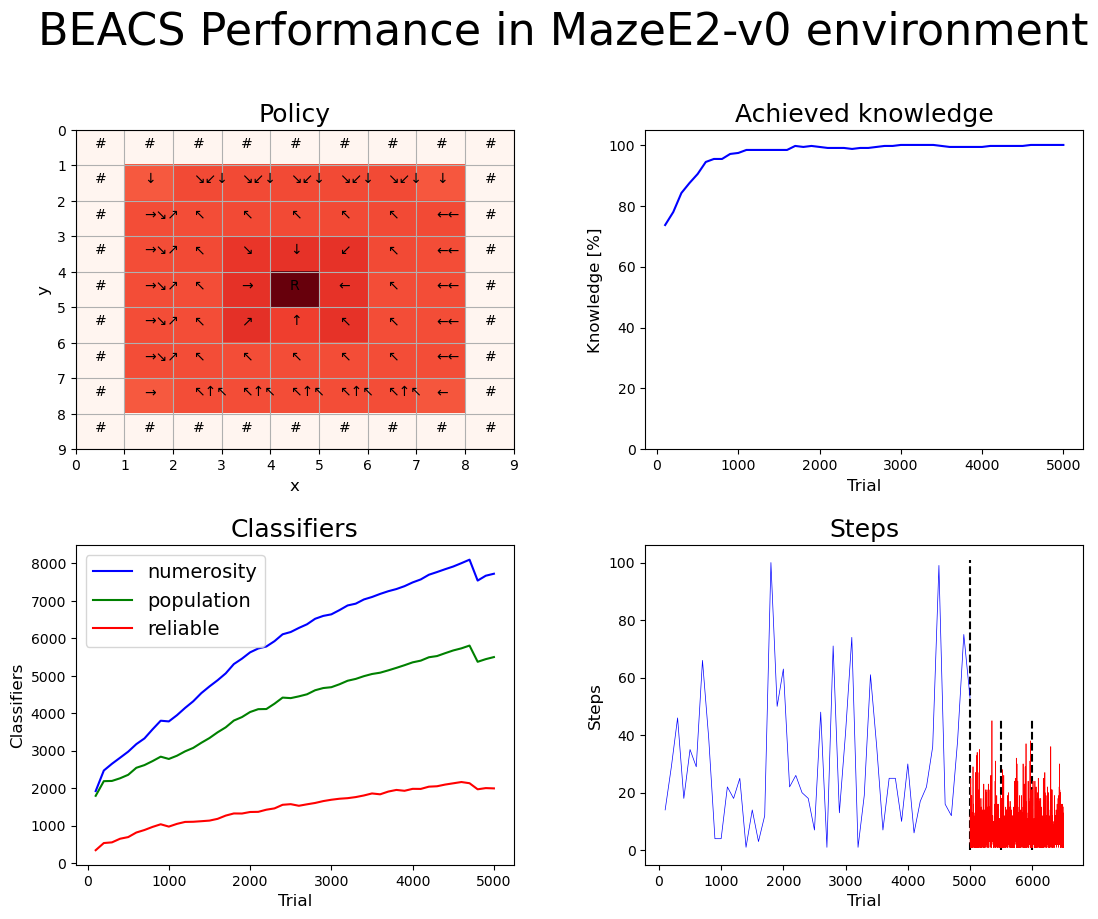

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  30.42  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  6.628  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  6.502  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  6.342  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 2983, 'numerosity': 4721, 'reliable': 574}
{'knowledge': 100.0, 'population': 2983, 'numerosity': 4721, 'reliable': 574}
{'knowledge': 100.0, 'population': 2983, 'numerosity': 4721, 'reliable': 574}
{'knowledge': 100.0, 'population': 2983, 'numerosity': 4721, 'reliable': 574}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl if not cl.is_experienced()]
#    if (not cl.behavioral_sequence)]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

2172


90000000 0 None (0#####9#:#1) (90000000)
q: 0.8903 ra: 984.8  rb: 975.6  ir: 847.3  f: 876.7  err: 34.01 
exp: 2     num: 1 ee: False PAI_state: 
tga: 141115 tbseq: 141326 talp: 141144 tav: 152.6  



900000#0 0 None (09######:#1) (empty)
q: 0.8774 ra: 984.1  rb: 976.9  ir: 847.3  f: 863.5  err: 33.11 
exp: 1     num: 1 ee: False PAI_state: 
tga: 141144 tbseq: 141326 talp: 141144 tav: 262.6  



00011100 7 [0, 7] (9##000##:#7, ###00#11:#127, ###000##:#234, ##9000##:#75, #9#000##:#6, ###0009#:#1) (empty)
q: 0.9995 ra: 853.5  rb: 864.7  ir: 96.92  f: 853.0  err: 55.46 
exp: 9     num: 1 ee: False PAI_state: 00011100
tga: 142081 tbseq: 140977 talp: 142081 tav: 122.7  



00000000 6 None (#####111:#394, ########:#643, ######9#:#82, #111####:#22, #######9:#48, #####9##:#72, 9#######:#3, ###111##:#11, 11#####1:#5, ####9###:#1) (empty)
q: 0.9998 ra: 834.0  rb: 845.8  ir: 0.0    f: 845.6  err: 11.41 
exp: 16    num: 1 ee: False PAI_state: 
tga: 141951 tbseq: 141517 talp: 142036 tav: 477



00#11111 5 None (###00###:#1) (00011111)
q: 0.7195 ra: 557.5  rb: 566.6  ir: 0.0    f: 407.7  err: 66.47 
exp: 6     num: 1 ee: False PAI_state: 
tga: 137731 tbseq: 141405 talp: 137731 tav: 2.917e+03 



1100#001 3 [1, 5] (##11####:#1) (empty)
q: 0.5    ra: 815.0  rb: 819.9  ir: 0.0    f: 407.5  err: 2.339 
exp: 1     num: 1 ee: False PAI_state: 00000000
tga: 141790 tbseq: 141790 talp: 141790 tav: 256.2  



00011111 1 [1] (#9#00000:#13, ########:#1, ######00:#1) (00011111)
q: 0.7135 ra: 537.2  rb: 605.0  ir: 0.0    f: 407.5  err: 40.75 
exp: 3     num: 1 ee: False PAI_state: 00011100
tga: 138552 tbseq: 131402 talp: 138552 tav: 2.383e+03 



11#00001 6 None (########:#1) (empty)
q: 0.5448 ra: 747.2  rb: 747.9  ir: 0.0    f: 407.4  err: 8.941 
exp: 3     num: 1 ee: False PAI_state: 
tga: 140004 tbseq: 141926 talp: 140004 tav: 1.682e+03 



0###0009 4 None (#######0:#1) (00000009)
q: 0.5499 ra: 723.5  rb: 740.9  ir: 10.77  f: 407.4  err: 21.12 
exp: 5     num: 1 ee: True PAI_state: 
tg




0#000111 2 [7] (########:#1) (empty)
q: 0.4708 ra: 520.6  rb: 475.9  ir: 0.0    f: 234.6  err: 66.3  
exp: 5     num: 1 ee: False PAI_state: 00000000
tga: 141714 tbseq: 139250 talp: 141714 tav: 534.8  



00000900 2 [1, 5] (#####0##:#1, 1111#0#1:#1) (empty)
q: 0.7056 ra: 355.3  rb: 330.9  ir: 0.0    f: 233.5  err: 21.82 
exp: 1     num: 1 ee: False PAI_state: 01110000
tga: 135983 tbseq: 135983 talp: 135983 tav: 0.0    



00##009# 3 None (#####90#:#1) (00000090)
q: 0.301  ra: 731.7  rb: 771.5  ir: 0.0    f: 232.2  err: 2.887 
exp: 2     num: 1 ee: False PAI_state: 
tga: 134029 tbseq: 141802 talp: 134029 tav: 2.271e+03 



111100#1 3 None (########:#1) (empty)
q: 0.4999 ra: 463.1  rb: 464.2  ir: 0.0    f: 232.1  err: 0.0   
exp: 1     num: 1 ee: False PAI_state: 
tga: 137379 tbseq: 141787 talp: 137379 tav: 2.98e+03 



00000090 3 None (#####90#:#1) (00000090)
q: 0.301  ra: 735.9  rb: 768.6  ir: 0.0    f: 231.3  err: 4.192 
exp: 2     num: 1 ee: False PAI_state: 
tga: 134029 tbseq: 14

00000##9 2 [7] (#####9#0:#1) (00000009)
q: 0.4196 ra: 160.3  rb: 157.7  ir: 0.0    f: 66.72  err: 266.4 
exp: 9     num: 1 ee: False PAI_state: 00000000
tga: 138338 tbseq: 92212 talp: 138338 tav: 5.125e+03 



0##9000# 0 [4] (###0####:#1) (00090000)
q: 0.2316 ra: 336.6  rb: 239.1  ir: 0.0    f: 66.67  err: 403.8 
exp: 16    num: 1 ee: False PAI_state: 00000000
tga: 130975 tbseq: 46726 talp: 130975 tav: 5.266e+03 



9#00###0 4 [1] (00#####9:#1) (90000000)
q: 0.3286 ra: 206.9  rb: 198.4  ir: 0.0    f: 66.59  err: 322.6 
exp: 11    num: 1 ee: False PAI_state: 00000000
tga: 140831 tbseq: 121067 talp: 140831 tav: 1.797e+03 



######90 1 [3, 3] (0111##0#:#1) (00000090)
q: 0.2156 ra: 308.8  rb: 326.0  ir: 25.67  f: 66.57  err: 401.4 
exp: 20    num: 1 ee: False PAI_state: 00000000
tga: 140608 tbseq: 77471 talp: 140608 tav: 3.157e+03 



00000#9# 5 [3, 4] (#111##0#:#1) (00000090)
q: 0.313  ra: 277.6  rb: 212.4  ir: 0.0    f: 66.47  err: 353.4 
exp: 15    num: 1 ee: True PAI_state: 00000000
t